# MNIST Side Quests!

Using intermediate loss to impose features within the network.

In this instance we can anthropomorphize a little bit. Normally, in a network, we use global loss to navigate from a starting position (usually random) to a final solution (usually highly performant). We can think of this our main quest: to get to the valley from wherever in the mountains that we "spawned" from.

Now, with this experiment, what we'd like to do, is impose features within the network. So, a network will optimize a function - traverse from random point to valley - in a somewhat random (and non-human interpretable way) path. What we want to do, is force the model to take parts of a path that we would traverse (that we would understand). To differently, we want the model to reach the optimal solution, but use techniques 'x' and 'y' on the way to the solution, where we understand 'x' and 'y', and can then better understand the answer provided by the model.

To do so, this notebook implements three layers: a horizontal edge layer, a verticaln edge layer, and a coupling (or classification) layer. The first two layers attempt to nudge the model to learn horizontal and vertical edges as intermediate features, respectively. The last layer will be piecing this information together to, ideally, identify the handwritten digit. In order to make this happen, in addition to the global loss (or the loss from our main quest), we have a loss for each of these two layers. Each edge layer outputs 784 values, which we can think of as a new image. This new image can then be used to computes a sub_loss, which can then be utilized to do backpropagation for the layer.

One important detail to note here, is that when calculating the sub_loss for the vertical edge layer, we only apply the gradients to the parameters in the vertical layer, because we don't want to impose vertical edges as an intermediate feature in the horizontal layer.

We can think of each of these sub_loss calculations as "weak" side quests. I say "weak", because these sub layers are still being impacted by the main quest (our global loss). We must keep this as a "weak" relationship, because otherwise this turns into a simple convolution reconstruction problem (i.e. it simplifies to horizontal edges + vertical edges = digit).

How much we pursue side quests is an interseting question... because side quests could be countering our main quest goal, and so it is theorectically possible to oscillate back and fourth on our way to the valley, caught in two minds: choose the side quest or choose the main quest.

Additionally, how we pursue side quests is an interesting question... do we impose such stringent rules on each sub layer?

## Imports

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Globals

In [2]:
MODEL_NAME = "./side_quests.pth"

## Set Device to GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [4]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [5]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

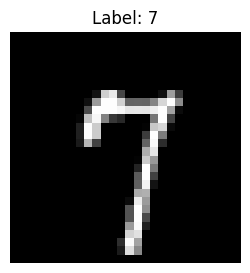

In [6]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Convolutions to get Horizontal Edges

### Example Image

In [7]:
horizontal_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0 , 0],
    [ 1,  1,  1],
])

In [8]:
horizontal_edges = get_edges(horizontal_kernel, sample_image)

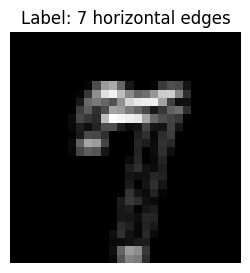

In [9]:
visualize_image(horizontal_edges, f"{sample_label} horizontal edges")

### Extending the Dataset

In [10]:
train_horizontal_image_labels = generate_intermediate_edge_labels(train_images, horizontal_kernel)

In [11]:
val_horizontal_image_labels = generate_intermediate_edge_labels(val_images, horizontal_kernel)

In [12]:
test_horizontal_image_labels = generate_intermediate_edge_labels(test_images, horizontal_kernel)

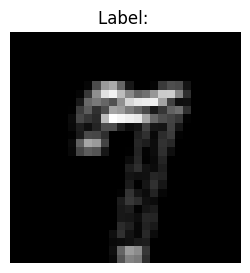

In [13]:
visualize_image(train_horizontal_image_labels[0].reshape(28, 28), "")

## Convolutions to get Vertical Edges

### Example Image

In [14]:
vertical_kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

In [15]:
vertical_edges = get_edges(vertical_kernel, sample_image)

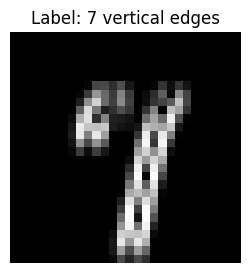

In [16]:
visualize_image(vertical_edges, f"{sample_label} vertical edges")

### Extending the Dataset

In [17]:
train_vertical_image_labels = generate_intermediate_edge_labels(train_images, vertical_kernel)

In [18]:
val_vertical_image_labels = generate_intermediate_edge_labels(val_images, vertical_kernel)

In [19]:
test_vertical_image_labels = generate_intermediate_edge_labels(test_images, vertical_kernel)

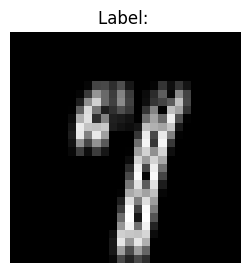

In [20]:
visualize_image(train_vertical_image_labels[0].reshape(28, 28), "")

# Our Test

## Architecture

We keep our two hidden layers at image size to be able to calculate a local loss to push those layers to learn human recognizable structures. However, for the example below, we don't calculate intermediate loss, as we need a basis.

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal layer
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical layer connected to horizontal layer
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # detached verision for vertical loss only
        # detached_input = horizontal_act.detach()
        # vertical_out_detached = self.vertical_layer(detached_input)
        # vertical_act_detached = self.activation_function(vertical_out_detached)

        # coupling layer
        classification_out = self.classification_layer(vertical_act)
        
        return classification_out, vertical_act, horizontal_act

In [22]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [23]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()
horizontal_loss_fn = nn.MSELoss()
vertical_loss_fn = nn.MSELoss()

# optimizers
horizontal_optimizer = torch.optim.Adam(model.horizontal_layer.parameters())
vertical_optimizer = torch.optim.Adam(model.vertical_layer.parameters())
classification_optimizer = torch.optim.Adam(model.classification_layer.parameters())

In [24]:
print(f"Model weights (to compare below): {model.horizontal_layer.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### Verify Reproducibility

In [25]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [26]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
            torch.from_numpy(self.horizontal_edges[idx].copy()).float(),
            torch.from_numpy(self.vertical_edges[idx].copy()).float(),
        )

In [27]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [28]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

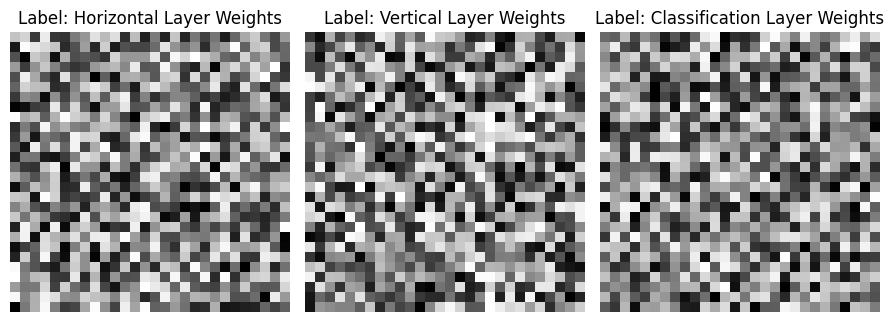

Epoch 1/20
  Train Loss: 5.3485
  Horizontal Edge Loss: 3.2464
  Vertical Edge Loss: 3.6418
  Val Loss: 4.0725 | Val Acc: 77.02%


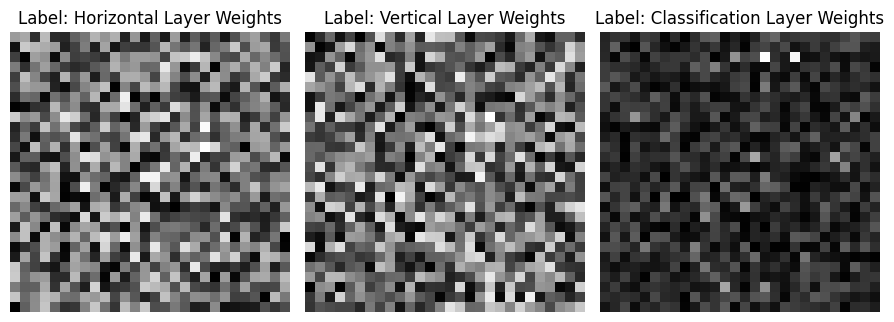

Epoch 2/20
  Train Loss: 4.2959
  Horizontal Edge Loss: 3.4108
  Vertical Edge Loss: 4.1398
  Val Loss: 5.1675 | Val Acc: 74.73%


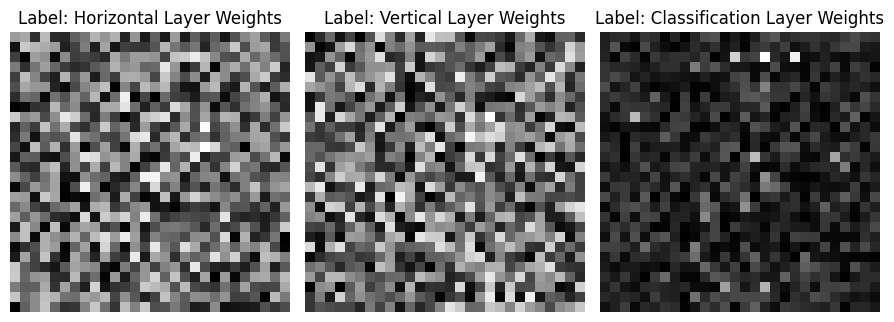

Epoch 3/20
  Train Loss: 5.0829
  Horizontal Edge Loss: 3.4498
  Vertical Edge Loss: 4.2335
  Val Loss: 8.9303 | Val Acc: 73.02%


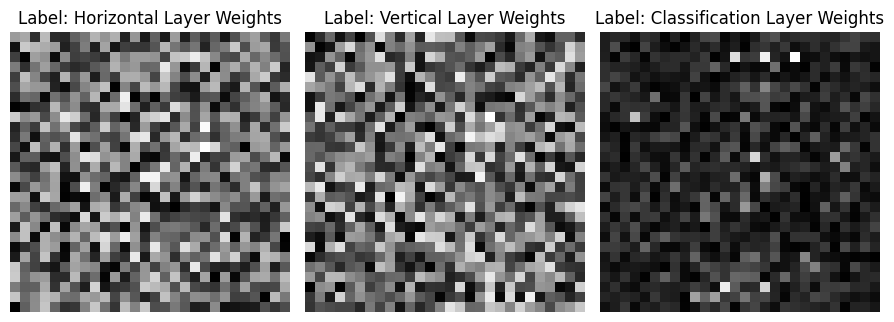

Epoch 4/20
  Train Loss: 4.8397
  Horizontal Edge Loss: 2.8572
  Vertical Edge Loss: 3.1087
  Val Loss: 6.0132 | Val Acc: 77.65%


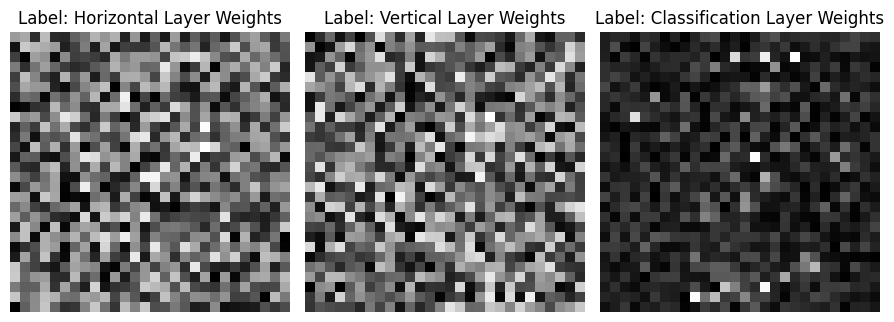

Epoch 5/20
  Train Loss: 5.5191
  Horizontal Edge Loss: 2.4069
  Vertical Edge Loss: 3.3966
  Val Loss: 7.0106 | Val Acc: 74.71%


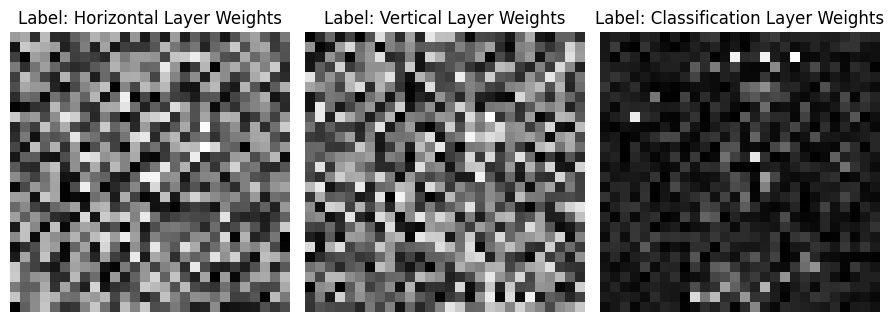

Epoch 6/20
  Train Loss: 5.0017
  Horizontal Edge Loss: 3.2579
  Vertical Edge Loss: 3.7484
  Val Loss: 4.6263 | Val Acc: 80.97%


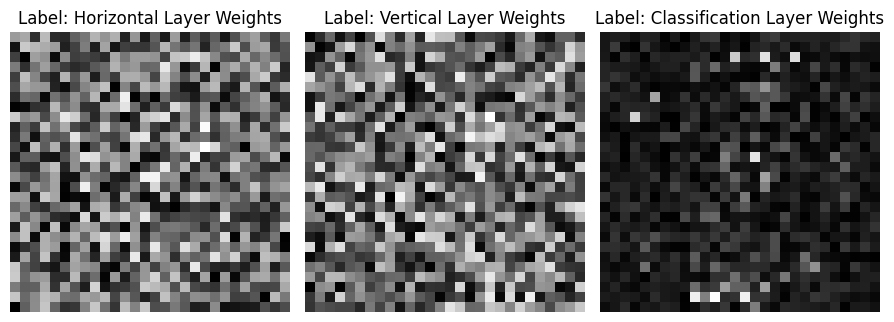

Epoch 7/20
  Train Loss: 4.8584
  Horizontal Edge Loss: 3.1763
  Vertical Edge Loss: 3.1461
  Val Loss: 5.1976 | Val Acc: 81.10%


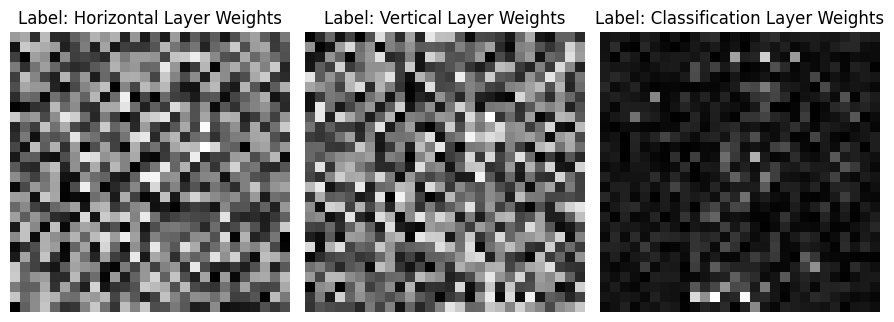

Epoch 8/20
  Train Loss: 4.9848
  Horizontal Edge Loss: 2.5785
  Vertical Edge Loss: 3.3311
  Val Loss: 6.2549 | Val Acc: 78.48%


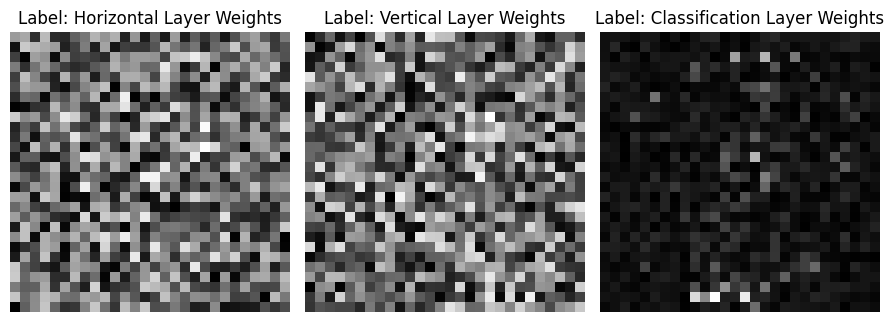

Epoch 9/20
  Train Loss: 5.1153
  Horizontal Edge Loss: 2.4988
  Vertical Edge Loss: 3.5060
  Val Loss: 5.5240 | Val Acc: 79.72%


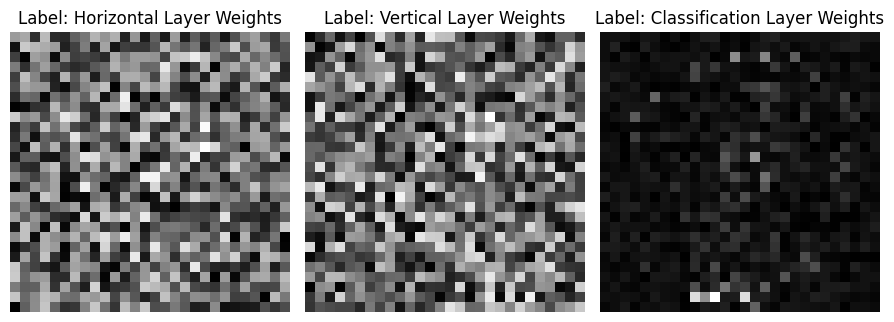

Epoch 10/20
  Train Loss: 5.1858
  Horizontal Edge Loss: 3.4535
  Vertical Edge Loss: 3.4697
  Val Loss: 6.3387 | Val Acc: 77.73%


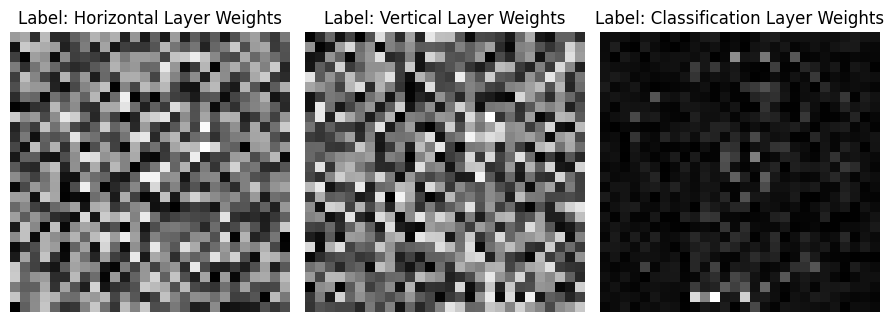

Epoch 11/20
  Train Loss: 5.1651
  Horizontal Edge Loss: 2.8856
  Vertical Edge Loss: 3.6207
  Val Loss: 7.8862 | Val Acc: 74.68%


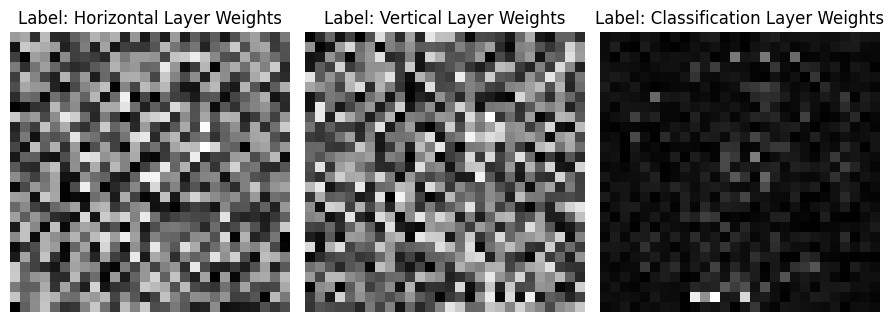

Epoch 12/20
  Train Loss: 5.2067
  Horizontal Edge Loss: 2.5997
  Vertical Edge Loss: 3.4058
  Val Loss: 3.7271 | Val Acc: 85.68%


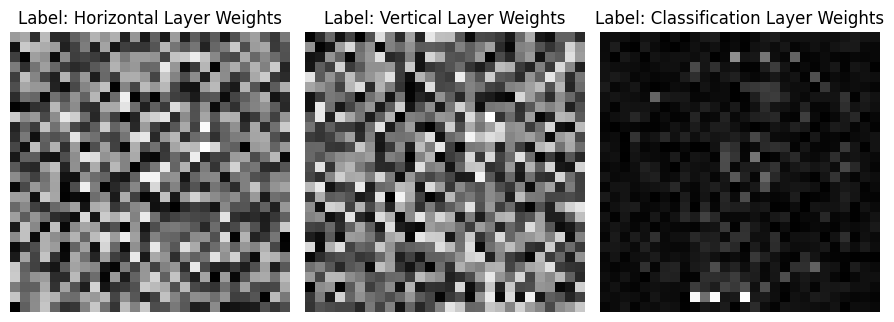

Epoch 13/20
  Train Loss: 5.2361
  Horizontal Edge Loss: 3.3471
  Vertical Edge Loss: 4.3229
  Val Loss: 5.3657 | Val Acc: 81.86%


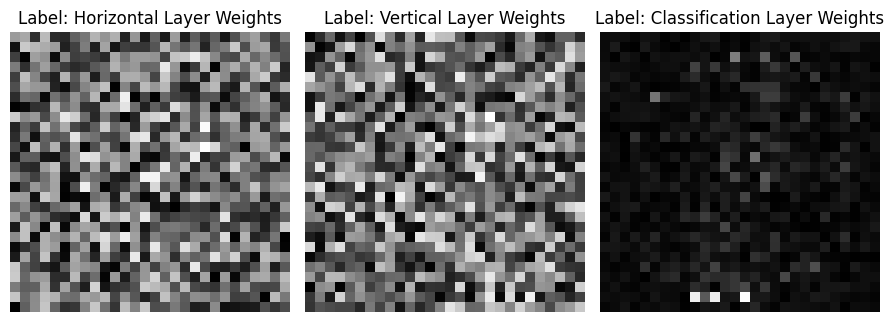

Epoch 14/20
  Train Loss: 4.9401
  Horizontal Edge Loss: 3.3837
  Vertical Edge Loss: 3.7542
  Val Loss: 4.0649 | Val Acc: 83.87%


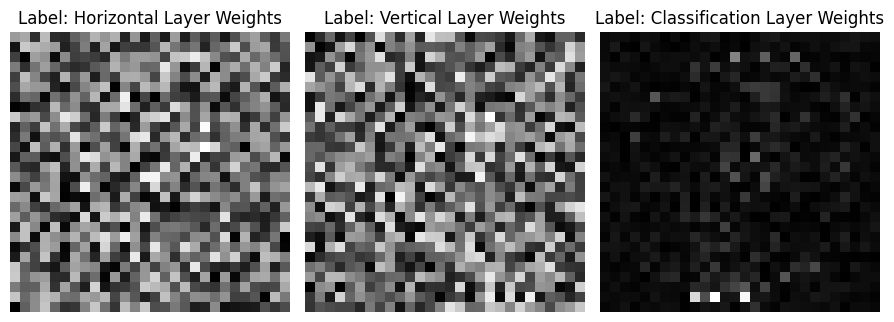

Epoch 15/20
  Train Loss: 5.3210
  Horizontal Edge Loss: 3.1308
  Vertical Edge Loss: 3.8609
  Val Loss: 4.6116 | Val Acc: 84.56%


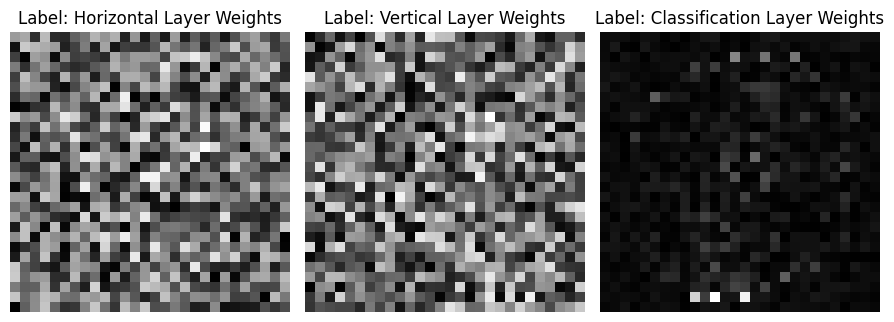

Epoch 16/20
  Train Loss: 5.1647
  Horizontal Edge Loss: 3.0473
  Vertical Edge Loss: 3.1364
  Val Loss: 4.4507 | Val Acc: 83.50%


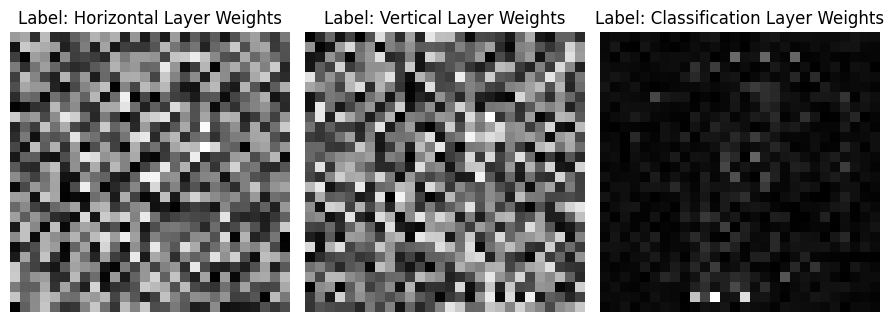

Epoch 17/20
  Train Loss: 5.1853
  Horizontal Edge Loss: 3.4282
  Vertical Edge Loss: 3.8409
  Val Loss: 7.1334 | Val Acc: 78.48%


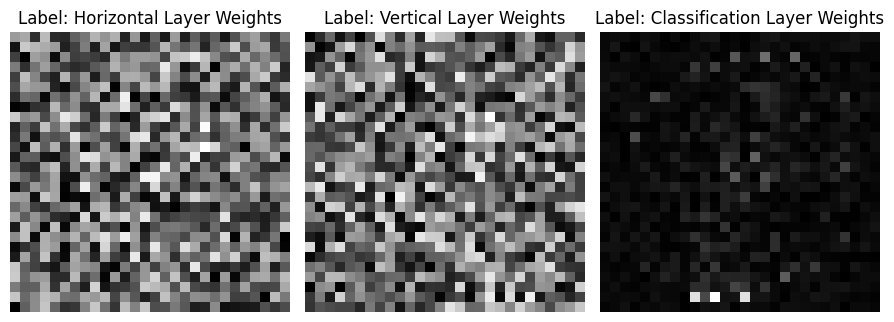

Epoch 18/20
  Train Loss: 5.9795
  Horizontal Edge Loss: 3.0861
  Vertical Edge Loss: 3.8428
  Val Loss: 6.4717 | Val Acc: 80.34%


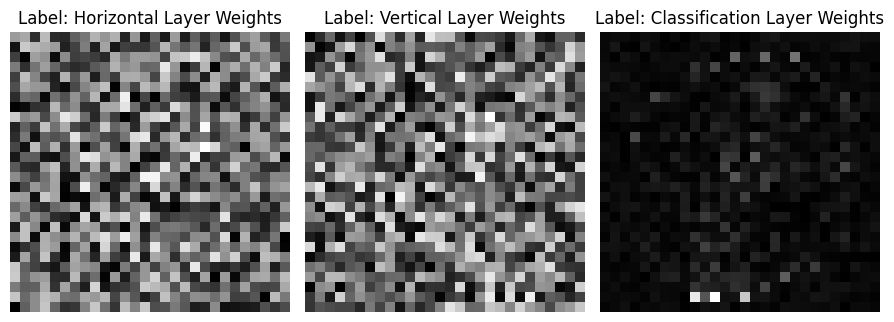

Epoch 19/20
  Train Loss: 5.0348
  Horizontal Edge Loss: 2.7781
  Vertical Edge Loss: 3.7644
  Val Loss: 4.2357 | Val Acc: 84.70%


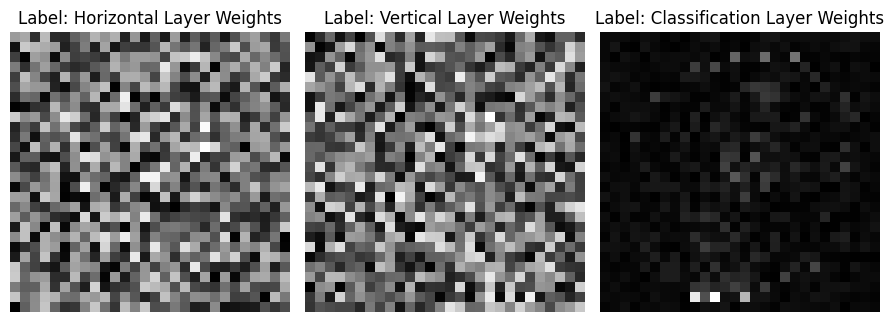

Epoch 20/20
  Train Loss: 5.1388
  Horizontal Edge Loss: 3.6776
  Vertical Edge Loss: 3.7118
  Val Loss: 4.8218 | Val Acc: 81.74%


In [29]:
num_epochs = 20
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0
    horizontal_loss = 0.0
    vertical_loss = 0.0

    # visualizing weights at each epoch
    classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    
    fig, axes = plt.subplots(1, 3, figsize=(9, 5))
    
    visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
    visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
    visualize_image(classification_w, "Classification Layer Weights", ax=axes[2])
    
    plt.tight_layout()
    plt.show()

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        
        # forward pass
        classification_out, vertical_act, horizontal_act = model(images)
        
        # --- Loss and Backprop ---

        # global update from the classification result
        classification_optimizer.zero_grad()
        classification_loss = classification_loss_fn(classification_out, labels)
        classification_loss.backward(retain_graph=True)
        classification_optimizer.step()
        
        # horizontal update
        horizontal_optimizer.zero_grad()
        horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels)
        horizontal_loss.backward(retain_graph=True)
        horizontal_optimizer.step()

        # vertical update
        vertical_optimizer.zero_grad()
        vertical_loss = vertical_loss_fn(vertical_act, vertical_labels)
        vertical_loss.backward()
        for name, param in model.named_parameters():
            if "vertical_layer" not in name:
                param.grad = None
        vertical_optimizer.step()

        # update progress
        train_loss += classification_loss.item()
        horizontal_loss += horizontal_loss.item()
        vertical_loss += vertical_loss.item()
        train_bar.set_postfix(loss=classification_loss.item())

    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_horizontal_loss = horizontal_loss / len(train_loader)
    avg_vertical_loss = vertical_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Horizontal Edge Loss: {avg_horizontal_loss:.4f}")
    print(f"  Vertical Edge Loss: {avg_vertical_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_NAME)

## Eval

In [30]:
model.load_state_dict(torch.load(MODEL_NAME))
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 380.22it/s]

Final Test Accuracy: 85.99%


# Exploring the Resulting Model

In [31]:
print(model.horizontal_layer.weight[0].shape)
print(model.horizontal_layer.bias.shape)

torch.Size([784])
torch.Size([784])


In [32]:
horizontal_layer_weights = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

## Visualizing Weights

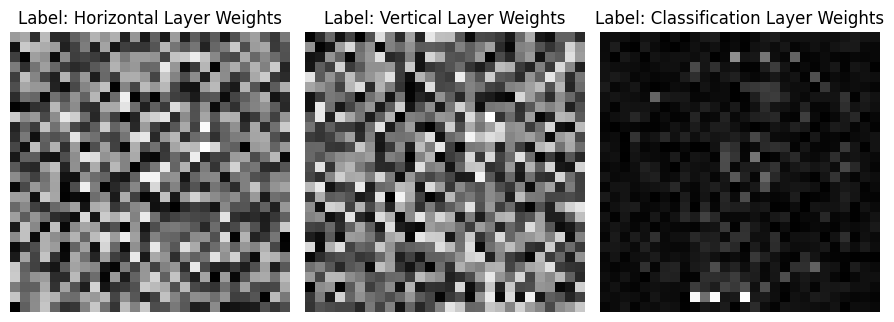

In [33]:
classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

fig, axes = plt.subplots(1, 3, figsize=(9, 5))

visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
visualize_image(classification_w, "Classification Layer Weights", ax=axes[2])

plt.tight_layout()
plt.show()